In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98280
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [4]:
data.drop_duplicates(subset = ['headlines'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98280


In [5]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


# 불용어 처리

In [6]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [7]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [8]:
clean_text = []

# 전체 headlines 데이터에 대한 전처리 
for s in data['headlines']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

['upgrad learner switches career ml al salary hike',
 'delhi techie wins free food swiggy one year cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'known hirani yrs metoo claims true sonam']

In [9]:
clean_summary = []

# 전체 text 데이터에 대한 전처리  
for s in data['text']:
    clean_summary.append(preprocess_sentence(s, False))

clean_summary[:5]

['saurav kant an alumnus of upgrad and iiit pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad degree career support helped him transition to data scientist at tech mahindra with salary hike upgrad online power learning has powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance to win free food from swiggy for one year pranav kaushik delhi techie bagged this reward after spending cred coins users get one cred coin per rupee of bill paid which can be used to avail rewards from brands like ixigo bookmyshow ubereats cult fit and more',
 'new zealand defeated india by wickets in the fourth odi at hamilton on thursday to win their first match of the five match odi series india lost an international match under rohit sharma captaincy after consecutive victories dating back to march the match witnessed india getting all out for their seventh lowest total

In [10]:
# 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있으므로 빈 값을 Null로 변환
data['headlines'] = clean_text
data['text'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [11]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

# 데이터 분석
- 헤드라인 길이와 텍스트 길이를 통해 값을 정할 수 있음

헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 13
헤드라인의 평균 길이 : 7.1367317867317865
텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 69
텍스트의 평균 길이 : 56.18174603174603


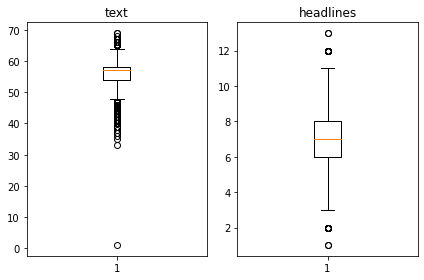

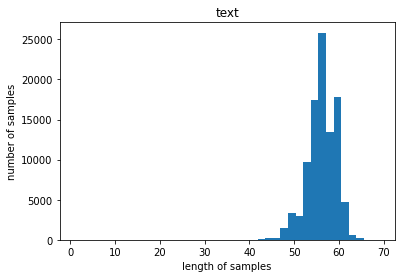

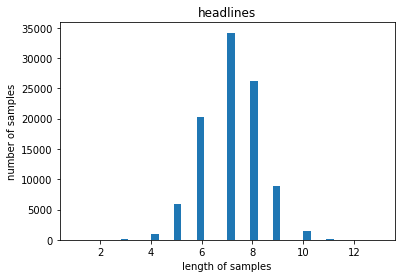

In [12]:
# 길이 분포 출력
import matplotlib.pyplot as plt

headlines_len = [len(s.split()) for s in data['headlines']]
text_len = [len(s.split()) for s in data['text']]

print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))
print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [13]:
# 최대길이 임의 설정
headlines_max_len = 11
text_max_len = 60

In [14]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [15]:
below_threshold_len(headlines_max_len, data['headlines'])
below_threshold_len(text_max_len,  data['text'])

전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9997456247456248
전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.9443630443630444


In [16]:
# 정해진 길이보다 길면 제외
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 92790


In [17]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches career ml al salary hike,saurav kant an alumnus of upgrad and iiit pg p...,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al salary hi...
1,delhi techie wins free food swiggy one year cred,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food swiggy on...,delhi techie wins free food swiggy one year cr...
2,new zealand end rohit sharma led india match w...,new zealand defeated india by wickets in the f...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,with aegon life iterm insurance plan customers...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,known hirani yrs metoo claims true sonam,speaking about the sexual harassment allegatio...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken


In [18]:
encoder_input = np.array(data['headlines']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [19]:
# 랜덤 정수 시퀀스를 이용하여 나눔
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[78643 60753 64767 ... 66797 17857 24916]


In [20]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# Train, Test data split

In [21]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 18558


In [22]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 74232
훈련 레이블의 개수 : 74232
테스트 데이터의 개수 : 18558
테스트 레이블의 개수 : 18558


In [23]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [24]:
threshold = 5 # 등장 빈도수
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29334
등장 빈도가 4번 이하인 희귀 단어의 수: 18238
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11096
단어 집합에서 희귀 단어의 비율: 62.173586963932635
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.936695412837099


In [25]:
src_vocab = 11000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 11,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

# 정수 형태 변환

In [26]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])
print(encoder_input_test[:3])

[[1253, 211, 294, 4236, 2250, 1383], [5524, 202, 1141, 3975, 6447, 80], [150, 8, 913, 16]]
[[253, 6475, 7167, 3654, 257, 3383, 40], [4, 18, 63, 225, 5827, 1372, 897], [61, 2435, 332, 212, 3374, 15, 304, 1011]]


In [27]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [28]:
threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29335
등장 빈도가 4번 이하인 희귀 단어의 수: 18238
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11097
단어 집합에서 희귀 단어의 비율: 62.17146753025396
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.2061402781691895


In [29]:
tar_vocab = 11000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1255, 213, 296, 4238, 2252, 1385], [1, 5526, 204, 1143, 3977, 6449, 82], [1, 152, 10, 915, 18], [1, 224, 264, 406, 343, 8374, 831, 402, 3304, 205], [1, 24, 252, 16, 7283, 18, 6122, 319, 583, 39, 411]]
target
decoder  [[1255, 213, 296, 4238, 2252, 1385, 2], [5526, 204, 1143, 3977, 6449, 82, 2], [152, 10, 915, 18, 2], [224, 264, 406, 343, 8374, 831, 402, 3304, 205, 2], [24, 252, 16, 7283, 18, 6122, 319, 583, 39, 411, 2]]


# 데이터 후처리

In [30]:
# 빈도수가 낮은 단어들로만 구성되었던 문장들을 제거
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 2
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 74230
훈련 레이블의 개수 : 74230
테스트 데이터의 개수 : 18557
테스트 레이블의 개수 : 18557


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [31]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = headlines_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = text_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = text_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = text_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = text_max_len, padding='post')


# 인코더 디코더 모델링

In [32]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128 # 임베딩벡터의 차원 수
hidden_size = 128 # LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터로 층 1개의 용량의 크기를 나타냄

# 인코더
encoder_inputs = Input(shape=(headlines_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 4개로 구성하여 모델의 용량을 늘림
# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output3, state_h3, state_c3= encoder_lstm3(encoder_output2)

# 인코더의 LSTM 4
encoder_lstm4 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm4(encoder_output3)

In [33]:
# 디코더 설계

decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
# dec_emb_layer = Embedding(tar_vocab, text_max_len)
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [34]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 11)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 11, 128)      1408000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 11, 128), (N 131584      embedding[0][0]                  
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 11, 128), (N 131584      lstm[0][0]                       
______________________________________________________________________________________________

In [35]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 11)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 11, 128)      1408000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 11, 128), (N 131584      embedding[0][0]                  
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 11, 128), (N 131584      lstm[0][0]                       
____________________________________________________________________________________________

# 모델 학습

In [36]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 5)

Epoch 1/5
290/290 [==============================] - 230s 743ms/step - loss: 1.7635 - val_loss: 0.9150
Epoch 2/5
290/290 [==============================] - 215s 743ms/step - loss: 0.9145 - val_loss: 0.8607
Epoch 3/5
290/290 [==============================] - 216s 744ms/step - loss: 0.8633 - val_loss: 0.8172
Epoch 4/5
290/290 [==============================] - 215s 743ms/step - loss: 0.8194 - val_loss: 0.7731
Epoch 5/5
290/290 [==============================] - 213s 736ms/step - loss: 0.7776 - val_loss: 0.7337


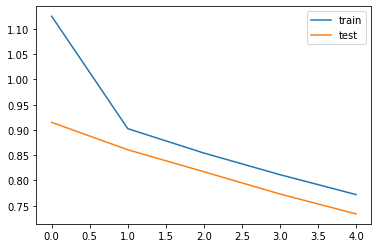

In [37]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [38]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [39]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [40]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(headlines_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [41]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복   
#         print(e_out.shape)
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (text_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [42]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

# 결과

In [43]:
for i in range(10, 20):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))    
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, headlines_max_len)))
    print("\n")

원문 : yr old nepalese youngest man hit int fifty beats sachin 
실제 요약 : yr old nepalese youngest man hit int fifty beats sachin 
예측 요약 :  yr old girl wins yr old old daughter


원문 : hindustan country hindus others rss 
실제 요약 : hindustan country hindus others rss 
예측 요약 :  thousands found due sale report


원문 : india nation status pak 
실제 요약 : india nation status pak 
예측 요약 :  india india largest


원문 : walmart plans create jobs new stores 
실제 요약 : walmart plans create jobs new stores 
예측 요약 :  flipkart may get flipkart new viral


원문 : djokovic defeats federer win record th masters title 
실제 요약 : djokovic defeats federer win record th masters title 
예측 요약 :  rohit hits odi odi odi odi odi


원문 : mp primary school students forced study toilet 
실제 요약 : mp primary school students forced study toilet 
예측 요약 :  bjp police bans sexual harassment sex


원문 : aamir khan starrer secret superstar hits theatres 
실제 요약 : aamir khan starrer secret superstar hits theatres 
예측 요약 :  trailer trailer star

# 고찰
- 텍스트 데이터들은 전처리가 매우 중요하면서도 복잡하다.
  - 이미지 데이터는 보통 그대로 사용하는 경우가 많다.
  - segmentation 이미지나 레이블을 한다해도 미리 되어있는 데이터셋을 쓰는 경우가 많다.
  - 하지만 텍스트 데이터는 날것의 것을 사용하면 처리해주어야할것 또는 데이터 분포를 보고 처리를 해야할 것들이 참 많은 것 같다.
- 요약, 추천, 작문 등등 텍스트 데이터들의 평가는 정량적 평가가 없다.
  - 결과를 보고 맞게 됐는지 아닌지를 판단하는 근거가 없는것이 아쉽다.
  - 분류 문제는 정확도가 있고 세그먼트 역시 IOU같은 지표를 통해 모델의 성능을 지표로 확인할 수 있지만 텍스트 데이터는 그것이 부족한것 같다.
## 결론
- 자연어 처리 작업은 나랑 맞지 않는것 같다ㅠ